In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load parquet file
path = Path("data/events_history.parquet")
df = pd.read_parquet(path)

print(f"Loaded {len(df):,} rows from {path}")

# Basic info
display(df.head())
print(df.info())
print("\nUnique snapshot dates:", df['snapshot_date'].nunique())
print("Date range:", df['snapshot_date'].min(), "→", df['snapshot_date'].max())

# Convert event date to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

Loaded 3,228 rows from data/events_history.parquet


,id,name,url,type,locale,date,time,status,onsale_date,offsale_date,...,artist,artist_id,segment,genre,subgenre,family,min_price,max_price,currency,snapshot_date
0,rZ7HnEZ1AfAbON,Ticket for you + 1 for ALL 2025 shows!,https://www.ticketweb.com/event/ticket-for-you...,event,en-us,2025-01-09,08:00:00,offsale,2025-01-09T13:35:00Z,2025-02-01T05:55:00Z,...,None,None,Music,World,World,False,199.00,199.00,USD,2025-11-03
1,G5dVZbbwUsOXz,Abono Temporada NY Jazz All Stars 2025,https://www.ticketmaster.com.mx/abono-temporad...,event,en-us,2025-09-06,20:30:00,onsale,2025-02-17T19:00:00Z,2025-11-23T02:30:00Z,...,None,None,Music,Jazz,Jazz,False,NaN,NaN,None,2025-11-03
2,ZFwVzcymWZ17keas,SYLVIE (USA) IN RESIDENCE AT THE ELTHAM,https://www.moshtix.com.au/v2/event/sylvie-usa...,event,en-us,2025-10-25,19:00:00,onsale,2025-06-18T20:30:00Z,2025-11-08T05:00:00Z,...,Sylvie,K8vZ917hjk7,Music,Rock,Indie Rock,False,NaN,NaN,None,2025-11-03
3,rZ7HnEZ1Af_6QK,MOBWEEN 3 NIGHT PASS - Acid Mothers Temple (10...,https://www.ticketweb.com/event/mobween-3-nigh...,event,en-us,2025-10-30,20:00:00,offsale,2025-10-27T22:00:00Z,2025-10-31T01:00:00Z,...,Widespread Panic,K8vZ91713Gf,Music,Alternative,Alternative Rock,False,49.51,49.51,USD,2025-11-03
4,rZ7HnEZ1AfbKPK,"Vinyl Weekend Pass (4 Rooms, 8+ Artists)",https://www.ticketweb.com/event/vinyl-weekend-...,event,en-us,2025-10-31,22:00:00,offsale,2025-10-10T16:00:00Z,2025-11-02T07:00:00Z,...,None,None,Music,Other,None,False,33.95,33.95,USD,2025-11-03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3228 entries, 0 to 3227
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3228 non-null   object 
 1   name           3228 non-null   object 
 2   url            3228 non-null   object 
 3   type           3228 non-null   object 
 4   locale         3228 non-null   object 
 5   date           3228 non-null   object 
 6   time           3212 non-null   object 
 7   status         3228 non-null   object 
 8   onsale_date    3207 non-null   object 
 9   offsale_date   3207 non-null   object 
 10  venue          3162 non-null   object 
 11  venue_id       3218 non-null   object 
 12  city           3208 non-null   object 
 13  state          2490 non-null   object 
 14  country        3217 non-null   object 
 15  venue_lat      3185 non-null   object 
 16  venue_lon      3184 non-null   object 
 17  artist         2716 non-null   object 
 18  artist_i

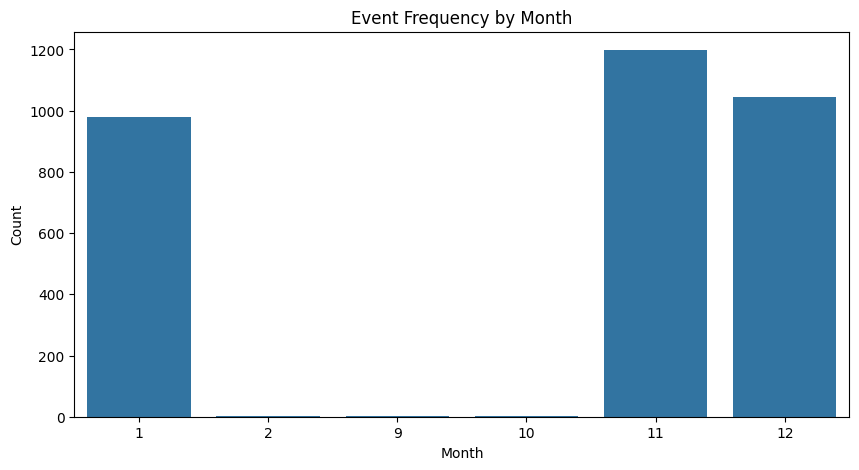

In [2]:
#Event frequency by month
plt.figure(figsize=(10,5))
sns.countplot(x='month', data=df, order=sorted(df['month'].dropna().unique()))
plt.title('Event Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

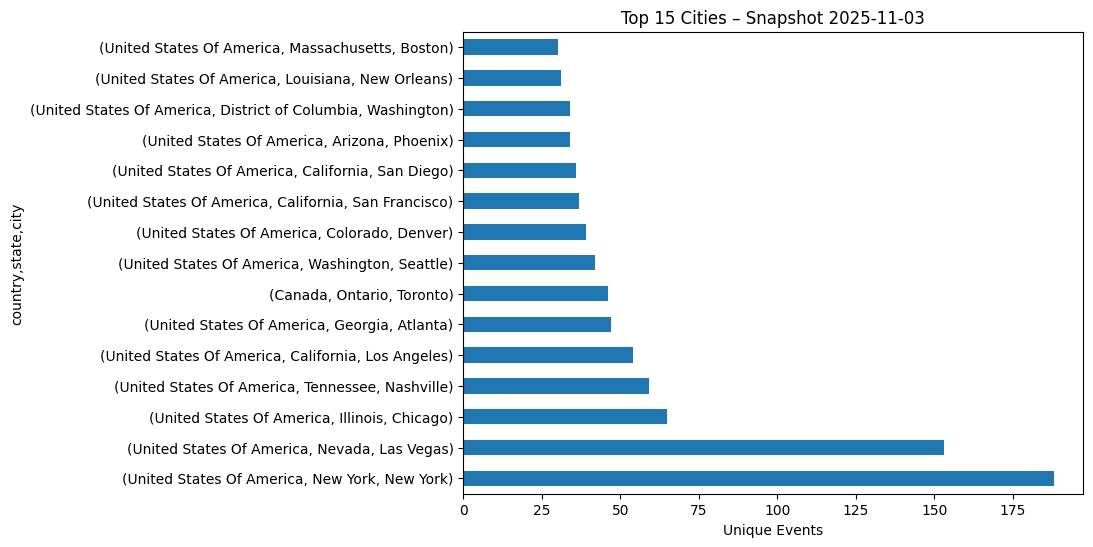

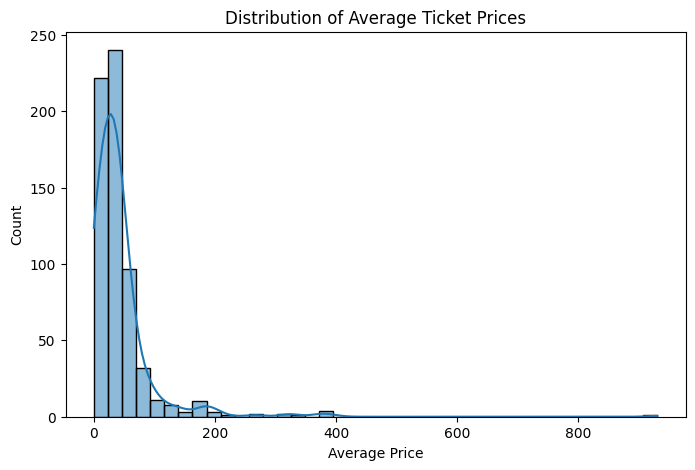

In [3]:
# Top 15 Cities by event count (latest snapshot)
latest_date = df['snapshot_date'].max()
latest_df = df[df['snapshot_date'] == latest_date]

top_cities = (
    latest_df.groupby(['country','state','city'])['id']
    .nunique()
    .sort_values(ascending=False)
    .head(15)
)
top_cities.plot(kind='barh', figsize=(8,6), title=f"Top 15 Cities – Snapshot {latest_date}")
plt.xlabel("Unique Events")
plt.show()

# Price range summary 
price_cols = ['min_price', 'max_price']
if df[price_cols].notna().any().any():
    df['avg_price'] = df[['min_price','max_price']].mean(axis=1)
    plt.figure(figsize=(8,5))
    sns.histplot(df['avg_price'].dropna(), bins=40, kde=True)
    plt.title("Distribution of Average Ticket Prices")
    plt.xlabel("Average Price")
    plt.show()
else:
    print("⚠️ No price data available in this snapshot.")


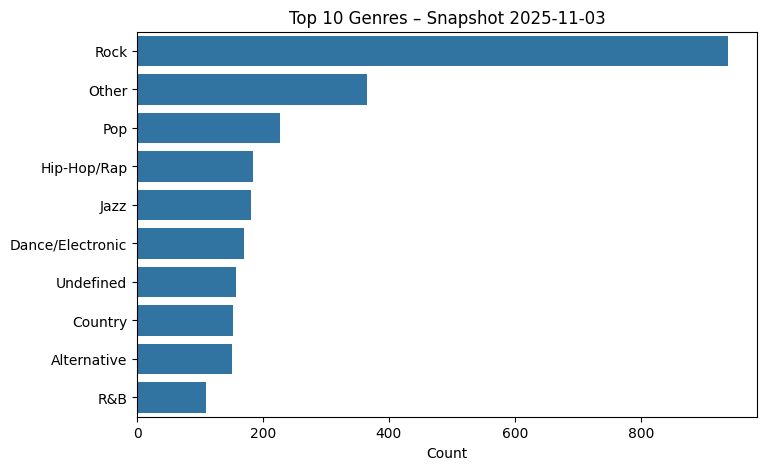

In [4]:
# Top genres
top_genres = (
    latest_df['genre']
    .value_counts()
    .head(10)
    .rename_axis('genre')
    .reset_index(name='count')
)
plt.figure(figsize=(8,5))
sns.barplot(data=top_genres, y='genre', x='count')
plt.title(f"Top 10 Genres – Snapshot {latest_date}")
plt.xlabel("Count")
plt.ylabel("")
plt.show()

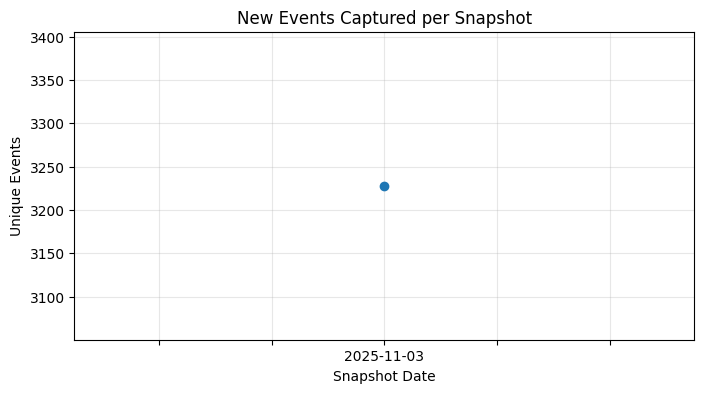

In [5]:
# Growth over time (how many new events appear each snapshot)
daily_counts = df.groupby('snapshot_date')['id'].nunique().sort_index()
plt.figure(figsize=(8,4))
daily_counts.plot(marker='o')
plt.title("New Events Captured per Snapshot")
plt.xlabel("Snapshot Date")
plt.ylabel("Unique Events")
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Quick cross-tab: events per country
country_counts = df.groupby('country')['id'].nunique().sort_values(ascending=False)
print(country_counts.head(20))

country
United States Of America    2081
Great Britain                461
Canada                       162
Australia                    116
Turkey                        76
Ireland                       62
Mexico                        41
Netherlands                   34
Germany                       34
Belgium                       30
Poland                        28
New Zealand                   18
Denmark                       16
Switzerland                   11
Austria                       10
Singapore                      9
Czech Republic                 8
Spain                          6
Sweden                         4
United Arab Emirates           3
Name: id, dtype: int64
